In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
results=pd.read_csv("MMPBSA_results.csv")
y_exp=results["Exp. dG (kcal/mol)"]
y_calc=results["Pred. dG (kcal/mol)"]
dy_exp=results["Estimated experimental error (kcal/mol)"]
dy_calc=results["Std. error of mean (kcal/mol)"]

In [2]:
def bootstrap_statistic(y_true, y_pred, dy_true=None, dy_pred=None, ci=0.95, statistic='RMSE', nbootstrap = 10000, plot_type='dG'):
    import sklearn.metrics
    import scipy
    """Compute mean and confidence intervals of specified statistic.

    Parameters
    ----------
    y_true : ndarray with shape (N,)
        True values
    y_pred : ndarray with shape (N,)
        Predicted values
    dy_true : ndarray with shape (N,) or None
        Errors of true values. If None, the values are assumed to have no errors
    dy_pred : ndarray with shape (N,) or None
        Errors of predicted values. If None, the values are assumed to have no errors
    ci : float, optional, default=0.95
        Interval for CI
    statistic : str
        Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','KTAU','RAE']
    nbootstrap : int, optional, default=10000
        Number of bootstrap samples
    plot_type : str, optional, default='dG'
        'dG' or 'ddG'

    Returns
    -------
    rmse_stats : dict of floeat
        'mean' : mean RMSE
        'stderr' : standard error
        'low' : low end of CI
        'high' : high end of CI
    """

    def compute_statistic(y_true_sample, y_pred_sample, statistic):
        """Compute requested statistic.

        Parameters
        ----------
        y_true : ndarray with shape (N,)
            True values
        y_pred : ndarray with shape (N,)
            Predicted values
        statistic : str
            Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','RAE','KTAU']

        """

        def calc_RAE(y_true_sample, y_pred_sample):
            MAE = sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
            mean = np.mean(y_true_sample)
            MAD = np.sum([np.abs(mean-i) for i in y_true_sample]) / float(len(y_true_sample))
            return MAE / MAD

        def calc_RRMSE(y_true_sample, y_pred_sample):
            rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample))
            mean_exp = np.mean(y_true_sample)
            mds = np.sum([(mean_exp - i) ** 2 for i in y_true_sample]) / float(len(y_true_sample))
            rrmse = np.sqrt(rmse ** 2 / mds)
            return rrmse

        if statistic == 'RMSE':
            return np.sqrt(sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample))
        elif statistic == 'MUE':
            return sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
        elif statistic == 'R2':
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true_sample, y_pred_sample)
            return r_value**2
        elif statistic == 'rho':
            return scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]
        elif statistic == 'RAE':
            return calc_RAE(y_true_sample, y_pred_sample)
        elif statistic == 'KTAU':
            return scipy.stats.kendalltau(y_true_sample, y_pred_sample)[0]
        else:
            raise Exception("unknown statistic '{}'".format(statistic))

    def unique_differences(x):
        """Compute all unique differences"""
        N = len(x)
        return np.array([(x[i] - x[j]) for i in range(N) for j in range(N) if (i != j)])

    if dy_true is None:
        dy_true = np.zeros_like(y_true)
    if dy_pred is None:
        dy_pred = np.zeros_like(y_pred)
    assert len(y_true) == len(y_pred)
    assert len(y_true) == len(dy_true)
    assert len(y_true) == len(dy_pred)
    sample_size = len(y_true)
    s_n = np.zeros([nbootstrap], np.float64) # s_n[n] is the statistic computed for bootstrap sample n
    for replicate in range(nbootstrap):
        y_true_sample = np.zeros_like(y_true)
        y_pred_sample = np.zeros_like(y_pred)
        for i,j in enumerate(np.random.choice(np.arange(sample_size), size=[sample_size], replace=True)):
            y_true_sample[i] = np.random.normal(loc=y_true[j], scale=np.fabs(dy_true[j]), size=1)
            y_pred_sample[i] = np.random.normal(loc=y_pred[j], scale=np.fabs(dy_pred[j]), size=1)
        s_n[replicate] = compute_statistic(y_true_sample, y_pred_sample, statistic)

    rmse_stats = dict()
    rmse_stats['mle'] = compute_statistic(y_true, y_pred, statistic)
    rmse_stats['stderr'] = np.std(s_n)
    rmse_stats['mean'] = np.mean(s_n)
    # TODO: Is there a canned method to do this?
    s_n = np.sort(s_n)
    low_frac = (1.0-ci)/2.0
    high_frac = 1.0 - low_frac
    rmse_stats['low'] = s_n[int(np.floor(nbootstrap*low_frac))]
    rmse_stats['high'] = s_n[int(np.ceil(nbootstrap*high_frac))]

    return s_n, rmse_stats

In [3]:
s_n, stat=bootstrap_statistic(y_exp, y_calc, dy_true=dy_exp, dy_pred=dy_calc)

(array([2.000e+00, 3.200e+01, 2.500e+02, 9.460e+02, 2.242e+03, 2.985e+03,
        2.317e+03, 9.960e+02, 2.060e+02, 2.400e+01]),
 array([2.04907067, 2.48082744, 2.91258422, 3.344341  , 3.77609777,
        4.20785455, 4.63961133, 5.0713681 , 5.50312488, 5.93488166,
        6.36663843]),
 <BarContainer object of 10 artists>)

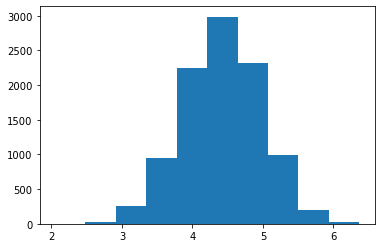

In [4]:
plt.hist(s_n)

In [5]:
print(stat)

{'mle': 4.407923514323382, 'stderr': 0.5557987152575125, 'mean': 4.423343209483398, 'low': 3.312694228633563, 'high': 5.48257397546426}


In [6]:
print(max(s_n))

6.366638433852702


In [7]:
print("The standard error of predicted binding affinities is:", stat['stderr'])

The standard error of predicted binding affinities is: 0.5557987152575125
